In [16]:
import requests
import json
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler

from data_manager import get_stock_data, get_one_to_one_stock_data

In [10]:
f = open("../api_key.txt", "r")
api_key = f.readline()

In [11]:
def plot_data(df, start=0, end=None):
    if end is None:
        end = len(df)
    plt.plot(df['Close'][start:end])
    plt.plot(df['Open'][start:end])
    plt.plot(df['Pred'][start:end])
    plt.legend(['Close', 'Open', 'Prediction'])
    plt.show()

In [12]:
def plot_diff(df, start=0, end=None):
    if end is None:
        end = len(df)
    my_df = pd.DataFrame()
    my_df['Actual Difference'] = df['Close'] - df['Open']
    my_df['Predicted Difference'] = df['Pred'] - df['Open']
    plt.bar(df.index[start:end], my_df['Actual Difference'][start:end], color='#ff000088')
    plt.bar(df.index[start:end], my_df['Predicted Difference'][start:end], color='#00ff0088')
    plt.legend(['Actual Difference', 'Predicted Difference'])
    plt.show()

In [13]:
def grab_my_predictions_rnn(pred_path):
    f = open(pred_path)
    pred_json = json.load(f)
    pred_data = []
    for entry in pred_json:
        pred_data.append(pred_json[entry])
    pred_data = np.asarray(pred_data).astype(float)
    return pred_data

In [26]:
df = pd.DataFrame()
df['Close'] = get_stock_data('DIS', api_key)['Prices']
df['Open'] = get_stock_data('DIS', api_key, ohcl='1. open')['Prices']
scaler = MinMaxScaler()
scaler = scaler.fit(df)
df = scaler.transform(df)
df = pd.DataFrame(df, columns=['Close', 'Open'])
df = df.shift(-50).dropna()
df['Pred'] = grab_my_predictions_rnn('../data/DIS_pred_rnn.json')
df.head()

,Close,Open,Pred
0,0.105879,0.118464,0.113517
1,0.111832,0.110739,0.115004
2,0.105188,0.112724,0.115420
3,0.110184,0.107037,0.114660
4,0.111513,0.110041,0.113685


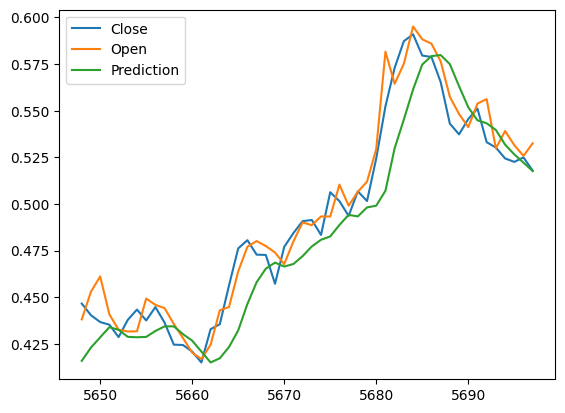

In [27]:
plot_data(df, start=len(df) - 50)

In [28]:
true_positive = 0
true_negative = 0
false_positive = 0
false_negative = 0
for i in range(len(df) - 300, len(df)):
    pred_buy = df['Pred'][i] > df['Open'][i]
    actual_buy = df['Close'][i] > df['Open'][i]
    if pred_buy and actual_buy:
        true_positive += 1
    if pred_buy and not actual_buy:
        false_positive += 1
    if not pred_buy and not actual_buy:
        true_negative += 1
    if not pred_buy and actual_buy:
        false_negative += 1
print("True positive: " + str(true_positive))
print("True negative: " + str(true_negative))
print("False positive: " + str(false_positive))
print("False negative: " + str(false_negative))

True positive: 15
True negative: 191
False positive: 32
False negative: 62


In [24]:
total = 100
plus = 0
minus = 0
fee = 0
lost = 0
for i in range(len(df) - 1000, len(df)):
    if df['Pred'][i] * (1.0 - fee) > df['Open'][i]:
        stocks = total / df['Open'][i]
        total = df['Close'][i] * stocks * (1.0 - fee)
        lost += df['Close'][i] * stocks * fee
        print("On day " + str(i) + " bought " + 
              str(stocks) + " stocks at " + 
              str(df['Open'][i]) + " and sold at " + str(df['Close'][i]) + 
              ". Total now is " + str(total))

On day 4739 bought 194.5969931092086 stocks at 0.5138825549266304 and sold at 0.5080790900393325. Total now is 98.87066318331696
On day 4740 bought 193.79544176488102 stocks at 0.5101805402795289 and sold at 0.508982672477942. Total now is 98.63852186353253
On day 4750 bought 180.68541422638341 stocks at 0.5459130294819862 and sold at 0.5521951738067398. Total now is 99.77361371308056
On day 4753 bought 181.95993142771547 stocks at 0.5483273868605306 and sold at 0.536887424258531. Total now is 97.69199890248508
On day 4754 bought 180.22689513451138 stocks at 0.5420500576763151 and sold at 0.5434782608695653. Total now is 97.94939952962577
On day 4757 bought 184.96756668013475 stocks at 0.5295490516940741 and sold at 0.5175932815988095. Total now is 95.73796982731756
On day 4758 bought 181.7675614369419 stocks at 0.5267054752260106 and sold at 0.5253534601892209. Total now is 95.49221735105422
On day 4759 bought 181.37487955748745 stocks at 0.5264908656812511 and sold at 0.5297650685659